<ipython-input-1-0d3b317e87cb>:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette        = plt.cm.get_cmap("tab10").colors


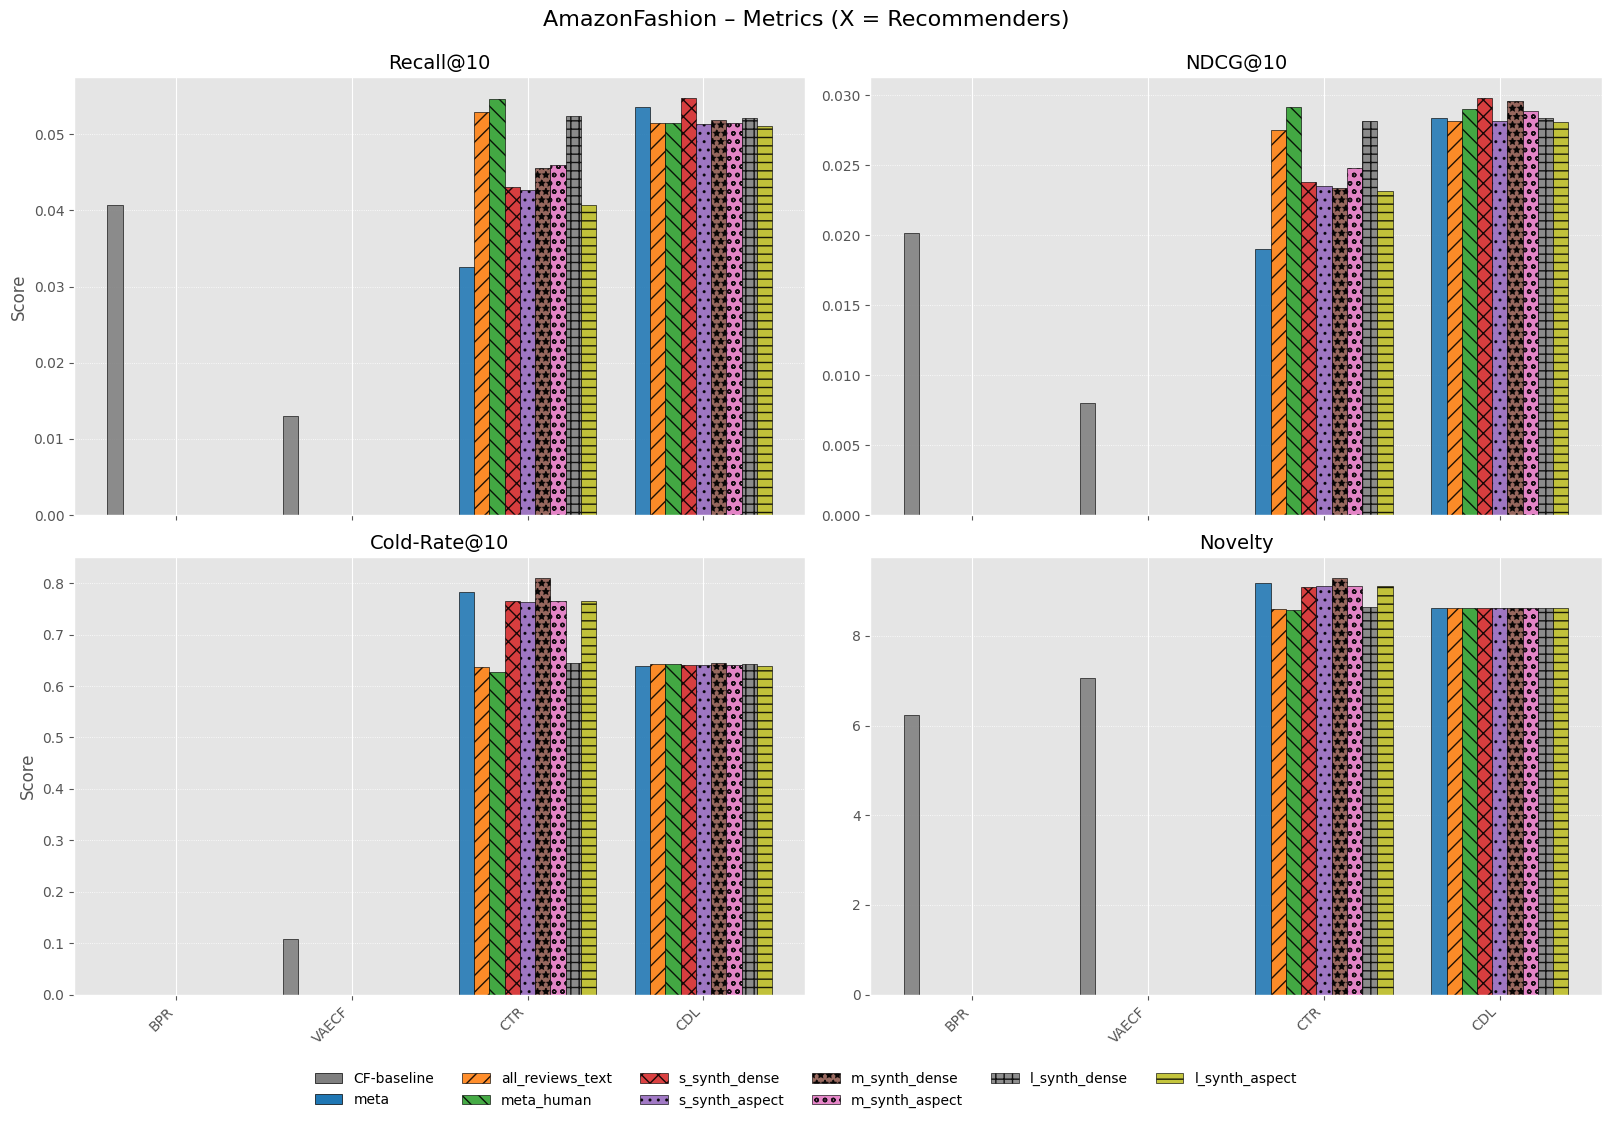

Saved: pretty_plots/AmazonFashion_by_model.png


In [ ]:
# ╔══════════════════  PRETTY 4-PANEL PLOT (CF-baseline + blue meta) ════════╗
import os, numpy as np, matplotlib.pyplot as plt
import matplotlib.patches as mpatches       # ← for custom legend handles
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# ── ❶  Experiment configuration ─────────────────────────────────────────────
RECS_FULL   = ["BPR", "VAECF", "CTR", "CDL"]          # x-axis order
BASELINES   = {"BPR", "VAECF"}                       # CF baselines
VARS = [
    "meta_only", "all_reviews_text", "meta_human",
    "s_synth_dense", "s_synth_aspect",
    "m_synth_dense", "m_synth_aspect",
    "l_synth_dense", "l_synth_aspect"
]
short = {  # shorter x-tick labels
    'meta_only':'meta', 'all_reviews_text':'all_txt', 'meta_human':'meta+hum',
    's_synth_dense':'s-dense', 's_synth_aspect':'s-aspect',
    'm_synth_dense':'m-dense', 'm_synth_aspect':'m-aspect',
    'l_synth_dense':'l-dense', 'l_synth_aspect':'l-aspect'
}

#  ──  Metric numbers (unchanged) ────────────────────────────────────────────
recall_values  = {
    "BPR"  : 0.0407,
    "VAECF": 0.0130,
    "CTR"  : [0.0326, 0.0529, 0.0546, 0.0431, 0.0427, 0.0456, 0.0459, 0.0524, 0.0407],
    "CDL"  : [0.0536, 0.0514, 0.0515, 0.0547, 0.0513, 0.0518, 0.0514, 0.0521, 0.0511],
}
ndcg_values    = {
    "BPR"  : 0.0202,
    "VAECF": 0.0080,
    "CTR"  : [0.0190, 0.0275, 0.0292, 0.0238, 0.0235, 0.0234, 0.0248, 0.0282, 0.0232],
    "CDL"  : [0.0284, 0.0282, 0.0290, 0.0298, 0.0282, 0.0296, 0.0289, 0.0284, 0.0281],
}
cold_values    = {
    "BPR"  : 0.0000,
    "VAECF": 0.1077,
    "CTR"  : [0.7819, 0.6374, 0.6277, 0.7659, 0.7625, 0.8103, 0.7651, 0.6449, 0.7642],
    "CDL"  : [0.6394, 0.6426, 0.6433, 0.6415, 0.6407, 0.6441, 0.6407, 0.6433, 0.6389],
}
novel_values   = {
    "BPR"  : 6.2375,
    "VAECF": 7.0564,
    "CTR"  : [9.1755, 8.6008, 8.5827, 9.1018, 9.1025, 9.2966, 9.1078, 8.6453, 9.1040],
    "CDL"  : [8.6199, 8.6314, 8.6308, 8.6244, 8.6248, 8.6318, 8.6244, 8.6280, 8.6255],
}

DATASET_NAME = "AmazonFashion"
FLAG         = "by_model"         # "by_model" | "by_variant"

# ── ❷  Build lookup tables (baselines stored only for 'meta_only') ──────────
tables = {met: {v: {} for v in VARS} for met in ["recall","ndcg","cold","novel"]}
for rec in RECS_FULL:
    if rec in BASELINES:
        for var in VARS:
            tables["recall"][var][rec] = recall_values[rec]  if var == "meta_only" else np.nan
            tables["ndcg"][var][rec]   = ndcg_values[rec]    if var == "meta_only" else np.nan
            tables["cold"][var][rec]   = cold_values[rec]    if var == "meta_only" else np.nan
            tables["novel"][var][rec]  = novel_values[rec]   if var == "meta_only" else np.nan
    else:
        for idx, var in enumerate(VARS):
            tables["recall"][var][rec] = recall_values[rec][idx]
            tables["ndcg"][var][rec]   = ndcg_values[rec][idx]
            tables["cold"][var][rec]   = cold_values[rec][idx]
            tables["novel"][var][rec]  = novel_values[rec][idx]

# ── ❸  Plotting style ───────────────────────────────────────────────────────
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (16, 10),
    "axes.titlesize": 14,  "axes.labelsize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10,
    "legend.fontsize": 10,
})
palette        = plt.cm.get_cmap("tab10").colors
baseline_color = "#7f7f7f"          # grey for CF-baseline bars
hatches        = ["", "//", "\\\\", "xx", "..", "**", "oo", "++", "--"]

metrics = ["recall","ndcg","cold","novel"]
titles  = ["Recall@10","NDCG@10","Cold-Rate@10","Novelty"]

fig, axes = plt.subplots(2, 2, sharex=True, constrained_layout=True)
axes = axes.ravel()

if FLAG == "by_model":
    x_bins, groups = RECS_FULL, len(RECS_FULL)
    bars, legend_items = len(VARS), VARS
else:
    x_bins, groups = VARS, len(VARS)
    bars, legend_items = len(RECS_FULL), RECS_FULL

x        = np.arange(groups)
bar_w    = 0.78 / bars
offsets  = np.linspace(-0.39 + bar_w/2, 0.39 - bar_w/2, bars)

# ── ❹  Draw bars ────────────────────────────────────────────────────────────
for m_idx, (met, ax) in enumerate(zip(metrics, axes)):
    if FLAG == "by_model":  # bars = VARIANTS
        for v_idx, var in enumerate(VARS):
            vals = [tables[met][var].get(rec, np.nan) for rec in RECS_FULL]

            # choose colour per bar
            bar_colors = [
                baseline_color if (rec in BASELINES and not np.isnan(vals[i]))
                else palette[v_idx % 10]
                for i, rec in enumerate(RECS_FULL)
            ]

            # label '_nolegend_' for meta variant (we'll add custom entry later)
            label = '_nolegend_' if var == "meta_only" else var
            ax.bar(x + offsets[v_idx], vals, width=bar_w,
                   color=bar_colors, edgecolor="black",
                   hatch=hatches[v_idx % len(hatches)], alpha=.88,
                   label=label)

    else:  # FLAG == "by_variant" – bars = RECOMMENDERS
        for r_idx, rec in enumerate(RECS_FULL):
            vals = [tables[met][var][rec] for var in VARS]
            colour = baseline_color if rec in BASELINES else palette[r_idx % 10]
            label  = '_nolegend_' if rec in BASELINES else rec
            ax.bar(x + offsets[r_idx], vals, width=bar_w,
                   color=colour, edgecolor="black",
                   hatch=hatches[r_idx % len(hatches)], alpha=.88,
                   label=label)

    ax.set_title(titles[m_idx])
    ax.grid(axis="y", ls=":", lw=.6)

# ── ❺  Axis labels ──────────────────────────────────────────────────────────
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels([short.get(lbl, lbl) for lbl in x_bins],
                       rotation=45, ha="right")
axes[0].set_ylabel("Score")
axes[2].set_ylabel("Score")

# ── ❻  Custom legend (CF-baseline + blue meta + others) ────────────────────
handles, labels = axes[0].get_legend_handles_labels()

# remove duplicates / '_nolegend_'
dedup = {}
for h, l in zip(handles, labels):
    if l != '_nolegend_' and l not in dedup:
        dedup[l] = h

# custom patches
baseline_patch = mpatches.Patch(facecolor=baseline_color, edgecolor="black",
                                label="CF-baseline")
meta_patch     = mpatches.Patch(facecolor=palette[0], edgecolor="black",
                                label="meta")

# rebuild ordered legend: CF-baseline, meta, then remaining variants
ordered_labels = ["CF-baseline", "meta"] + \
                 [lbl for lbl in VARS if lbl not in ("meta_only",)]  # others

ordered_handles = [baseline_patch, meta_patch] + \
                  [dedup[lbl] for lbl in ordered_labels if lbl in dedup]

fig.legend(ordered_handles, ordered_labels,
           ncol=min(len(ordered_labels), 6),
           loc="lower center", bbox_to_anchor=(0.5, -0.07), frameon=False)

# ── ❼  Title, save, show ───────────────────────────────────────────────────
fig.suptitle(f"{DATASET_NAME} – Metrics "
             f"({'X = Recommenders' if FLAG == 'by_model' else 'X = Variants'})",
             fontsize=16, y=1.04)

os.makedirs("pretty_plots", exist_ok=True)
outfile = f"pretty_plots/{DATASET_NAME}_{FLAG}.png".replace(" ", "_")
fig.savefig(outfile, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", outfile)


<ipython-input-3-30e7575a19a9>:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette        = plt.cm.get_cmap("tab10").colors


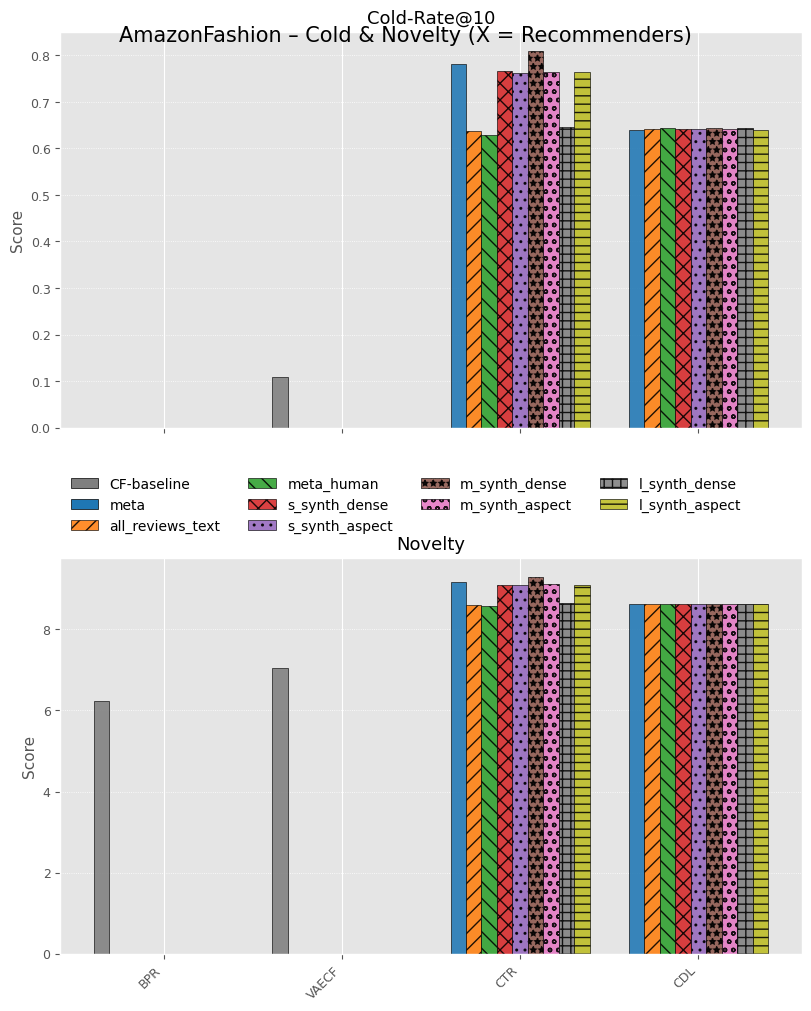

Saved: pretty_plots/AmazonFashion_cold_novel.png


In [ ]:
"""
Standalone script
~~~~~~~~~~~~~~~~~
Plots **Cold-Rate@10** (top) and **Novelty** (bottom) for the Amazon-Fashion
experiment.  Collaborative-filtering baselines (BPR, VAECF) appear once, in
grey, and share a single legend entry “CF-baseline”.  The “meta” variant is
blue.  All other variants keep the default colour cycle.  The legend sits
between the two vertical sub-plots.
"""
import os, numpy as np, matplotlib.pyplot as plt
import matplotlib.patches as mpatches
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# ── 1.  Configuration ───────────────────────────────────────────────────────
RECS_FULL = ["BPR", "VAECF", "CTR", "CDL"]          # x-axis order
BASELINES = {"BPR", "VAECF"}                       # CF baselines
VARS = [
    "meta_only", "all_reviews_text", "meta_human",
    "s_synth_dense", "s_synth_aspect",
    "m_synth_dense", "m_synth_aspect",
    "l_synth_dense", "l_synth_aspect"
]
short = {  # shorter x-tick labels
    'meta_only':'meta', 'all_reviews_text':'all_txt', 'meta_human':'meta+hum',
    's_synth_dense':'s-dense', 's_synth_aspect':'s-aspect',
    'm_synth_dense':'m-dense', 'm_synth_aspect':'m-aspect',
    'l_synth_dense':'l-dense', 'l_synth_aspect':'l-aspect'
}

#   Metric numbers
cold_values = {
    "BPR"  : 0.0000,
    "VAECF": 0.1077,
    "CTR"  : [0.7819, 0.6374, 0.6277, 0.7659, 0.7625, 0.8103, 0.7651, 0.6449, 0.7642],
    "CDL"  : [0.6394, 0.6426, 0.6433, 0.6415, 0.6407, 0.6441, 0.6407, 0.6433, 0.6389],
}
novel_values = {
    "BPR"  : 6.2375,
    "VAECF": 7.0564,
    "CTR"  : [9.1755, 8.6008, 8.5827, 9.1018, 9.1025, 9.2966, 9.1078, 8.6453, 9.1040],
    "CDL"  : [8.6199, 8.6314, 8.6308, 8.6244, 8.6248, 8.6318, 8.6244, 8.6280, 8.6255],
}

DATASET_NAME = "AmazonFashion"
FLAG         = "by_model"         # "by_model" | "by_variant"

# ── 2.  Build lookup tables (baselines stored only for 'meta_only') ─────────
tables = {met: {v:{} for v in VARS} for met in ["cold","novel"]}
for rec in RECS_FULL:
    if rec in BASELINES:
        for var in VARS:
            tables["cold"][var][rec]  = cold_values[rec]  if var=="meta_only" else np.nan
            tables["novel"][var][rec] = novel_values[rec] if var=="meta_only" else np.nan
    else:
        for idx,var in enumerate(VARS):
            tables["cold"][var][rec]  = cold_values[rec][idx]
            tables["novel"][var][rec] = novel_values[rec][idx]

# ── 3.  Plotting style ──────────────────────────────────────────────────────
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (8, 10),
    "axes.titlesize": 13,"axes.labelsize": 11,
    "xtick.labelsize": 9,"ytick.labelsize": 9,
    "legend.fontsize": 10,
})
palette        = plt.cm.get_cmap("tab10").colors
baseline_color = "#7f7f7f"          # grey for CF-baseline bars
hatches        = ["", "//", "\\\\", "xx", "..", "**", "oo", "++", "--"]

metrics = ["cold","novel"]
titles  = ["Cold-Rate@10","Novelty"]

fig, axes = plt.subplots(
    2, 1,
    sharex=True,
    constrained_layout=True,
    gridspec_kw={'hspace': 0.2}
)

x_bins, groups = RECS_FULL, len(RECS_FULL)
bars, legend_items = len(VARS), VARS




x       = np.arange(groups)
bar_w   = 0.78 / bars
offsets = np.linspace(-0.39 + bar_w/2, 0.39 - bar_w/2, bars)

# ── 4.  Draw bars ───────────────────────────────────────────────────────────
for m_idx,(met,ax) in enumerate(zip(metrics,axes)):
    for v_idx,var in enumerate(VARS):
        vals = [tables[met][var].get(rec,np.nan) for rec in RECS_FULL]
        bar_colors = [
            baseline_color if (rec in BASELINES and not np.isnan(vals[i]))
            else palette[v_idx % 10]
            for i,rec in enumerate(RECS_FULL)
        ]
        label = '_nolegend_' if var=="meta_only" else var
        ax.bar(x+offsets[v_idx], vals, width=bar_w,
               color=bar_colors, edgecolor="black",
               hatch=hatches[v_idx%len(hatches)], alpha=.88,
               label=label)
    ax.set_title(titles[m_idx]); ax.grid(axis="y", ls=":", lw=.6)
    ax.set_ylabel("Score")

axes[-1].set_xticks(x)
axes[-1].set_xticklabels([short.get(lbl,lbl) for lbl in x_bins],
                         rotation=45, ha="right")

# ── 5.  Custom legend placed between sub-plots ──────────────────────────────
handles, labels = axes[0].get_legend_handles_labels()
dedup={}
for h,l in zip(handles,labels):
    if l!='_nolegend_' and l not in dedup:
        dedup[l]=h

baseline_patch = mpatches.Patch(facecolor=baseline_color, edgecolor="black",
                                label="CF-baseline")
meta_patch     = mpatches.Patch(facecolor=palette[0], edgecolor="black",
                                label="meta")
ordered_labels = ["CF-baseline","meta"] + \
                 [lbl for lbl in VARS if lbl not in ("meta_only",)]
ordered_handles= [baseline_patch,meta_patch]+\
                 [dedup[lbl] for lbl in ordered_labels if lbl in dedup]

fig.legend(ordered_handles, ordered_labels,
           ncol=min(len(ordered_labels),4),
           loc="center", bbox_to_anchor=(0.5,0.5), frameon=False)

# ── 6.  Title, save, show ──────────────────────────────────────────────────
fig.suptitle(f"{DATASET_NAME} – Cold & Novelty "
             "(X = Recommenders)", fontsize=15, y=0.98)

os.makedirs("pretty_plots", exist_ok=True)
outfile=f"pretty_plots/{DATASET_NAME}_cold_novel.png".replace(" ","_")
fig.savefig(outfile, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", outfile)


<ipython-input-8-9b70f69fff80>:77: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors  = plt.cm.get_cmap("tab10").colors
<ipython-input-8-9b70f69fff80>:85: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.4)


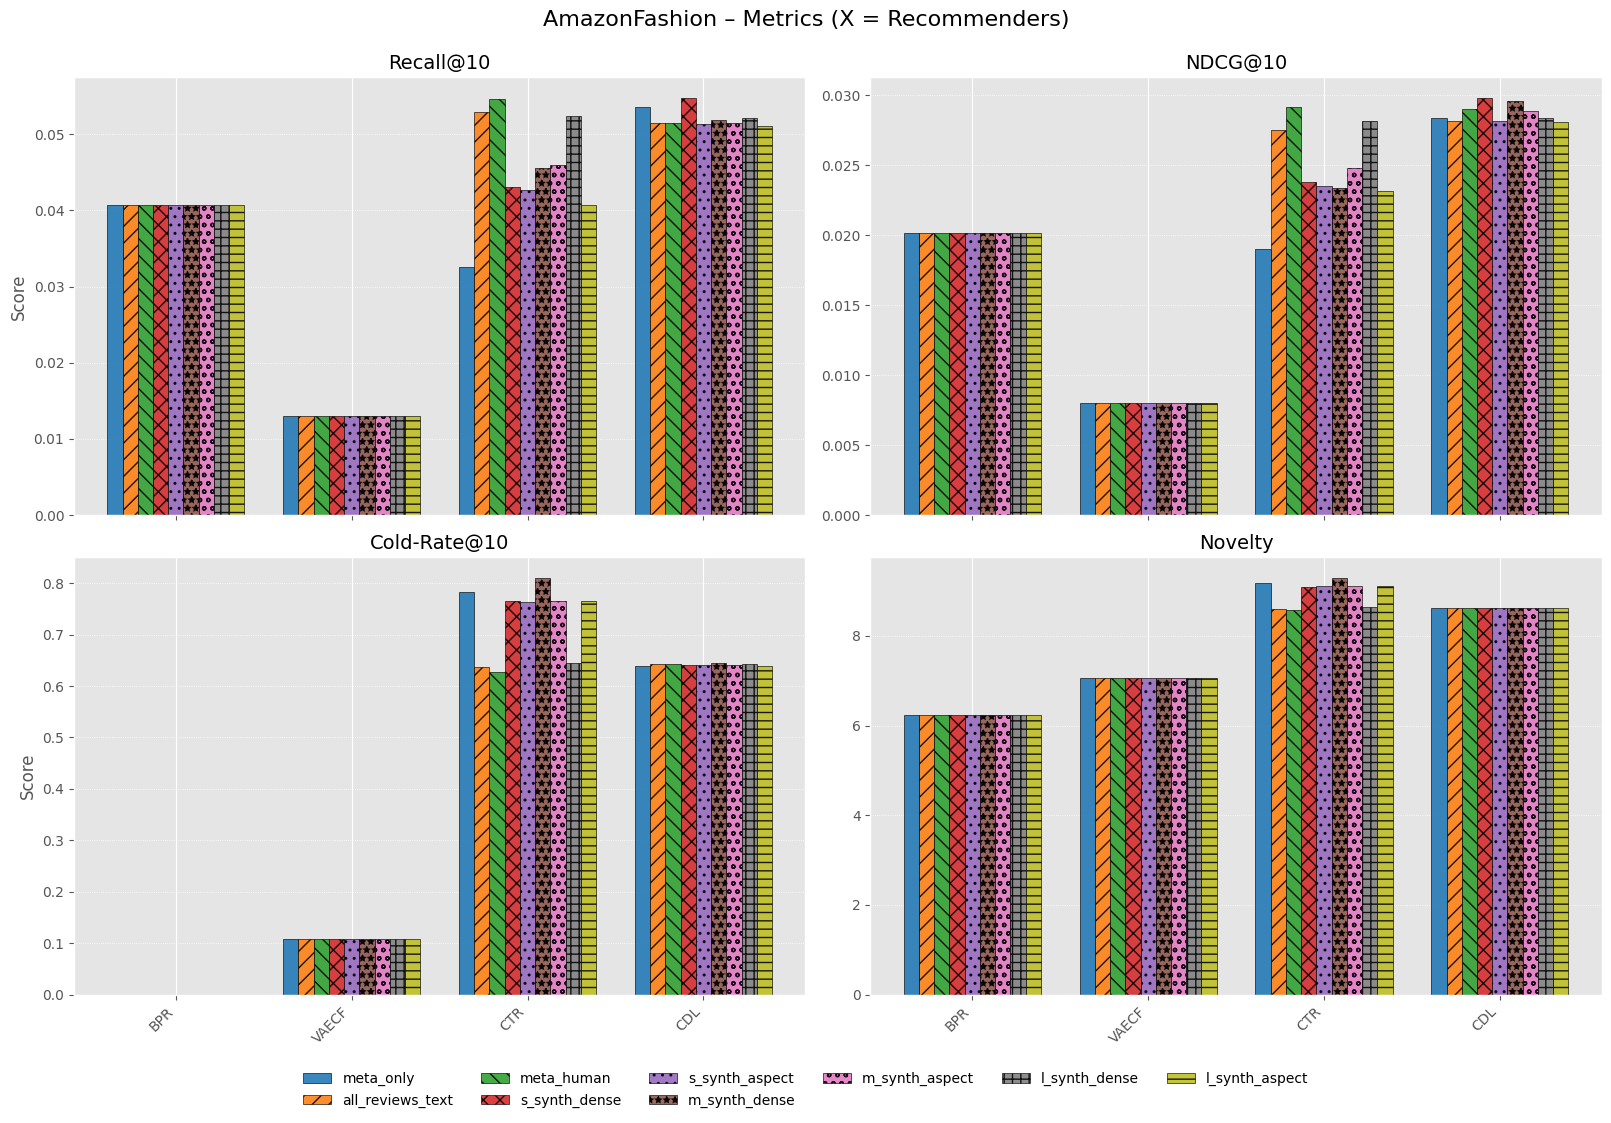

Saved: pretty_plots/AmazonFashion_by_model.png


In [ ]:
# ╔══════════════════  PRETTY 4-PANEL PLOT (Baselines fixed) ═════════════════╗
import os, numpy as np, matplotlib.pyplot as plt
os.environ["OPENBLAS_NUM_THREADS"] = "1"

# ── ❶  Experiment configuration ─────────────────────────────────────────────
RECS_FULL = ["BPR", "VAECF", "CTR", "CDL"]             # plotting order
BASELINES = {"BPR", "VAECF"}                           # no augmentation effect
VARS = [
    "meta_only", "all_reviews_text", "meta_human",
    "s_synth_dense", "s_synth_aspect",
    "m_synth_dense", "m_synth_aspect",
    "l_synth_dense", "l_synth_aspect"
]
short = {  # shorter x-tick labels
    'meta_only':'meta', 'all_reviews_text':'all_txt', 'meta_human':'meta+hum',
    's_synth_dense':'s-dense', 's_synth_aspect':'s-aspect',
    'm_synth_dense':'m-dense', 'm_synth_aspect':'m-aspect',
    'l_synth_dense':'l-dense', 'l_synth_aspect':'l-aspect'
}

#  ──  Your true metric numbers  ─────────────────────────────────────────────
#  For baselines (BPR, VAECF): give ONE value per metric
#  For CTR & CDL: give NINE values (one per VARS entry) per metric

recall_values  = {
    "BPR"  : 0.0407,
    "VAECF": 0.0130,
    "CTR"  : [0.0326, 0.0529, 0.0546, 0.0431, 0.0427, 0.0456, 0.0459, 0.0524, 0.0407],
    "CDL"  : [0.0536, 0.0514, 0.0515, 0.0547, 0.0513, 0.0518, 0.0514, 0.0521, 0.0511],
}
ndcg_values    = {
    "BPR"  : 0.0202,
    "VAECF": 0.0080,
    "CTR"  : [0.0190, 0.0275, 0.0292, 0.0238, 0.0235, 0.0234, 0.0248, 0.0282, 0.0232],
    "CDL"  : [0.0284, 0.0282, 0.0290, 0.0298, 0.0282, 0.0296, 0.0289, 0.0284, 0.0281],
}
cold_values    = {
    "BPR"  : 0.0000,
    "VAECF": 0.1077,
    "CTR"  : [0.7819, 0.6374, 0.6277, 0.7659, 0.7625, 0.8103, 0.7651, 0.6449, 0.7642],
    "CDL"  : [0.6394, 0.6426, 0.6433, 0.6415, 0.6407, 0.6441, 0.6407, 0.6433, 0.6389],
}
novel_values   = {
    "BPR"  : 6.2375,
    "VAECF": 7.0564,
    "CTR"  : [9.1755, 8.6008, 8.5827, 9.1018, 9.1025, 9.2966, 9.1078, 8.6453, 9.1040],
    "CDL"  : [8.6199, 8.6314, 8.6308, 8.6244, 8.6248, 8.6318, 8.6244, 8.6280, 8.6255],
}

DATASET_NAME  = "AmazonFashion"
FLAG          = "by_model"        #  "by_model"  |  "by_variant"

# ── ❷  Assemble a unified lookup table: metric → variant → recommender → value
tables = {met: {v:{} for v in VARS} for met in ["recall","ndcg","cold","novel"]}
for rec, base in recall_values.items():   # repeat baseline values for every variant
    if rec in BASELINES:
        for var in VARS:
            tables["recall"][var][rec] = base
            tables["ndcg"][var][rec]   = ndcg_values[rec]
            tables["cold"][var][rec]   = cold_values[rec]
            tables["novel"][var][rec]  = novel_values[rec]
    else:                                # CTR/CDL  (lists)
        for var_idx, var in enumerate(VARS):
            tables["recall"][var][rec] = recall_values[rec][var_idx]
            tables["ndcg"][var][rec]   = ndcg_values[rec][var_idx]
            tables["cold"][var][rec]   = cold_values[rec][var_idx]
            tables["novel"][var][rec]  = novel_values[rec][var_idx]

# ── ❸  Plotting aesthetics  ────────────────────────────────────────────
plt.style.use("ggplot")
plt.rcParams.update({
    "figure.figsize": (16, 10),
    "axes.titlesize": 14, "axes.labelsize": 12,
    "xtick.labelsize": 10,"ytick.labelsize": 10,
    "legend.fontsize": 10,
})
colors  = plt.cm.get_cmap("tab10").colors
hatches = ["", "//", "\\\\", "xx", "..", "**", "oo", "++", "--"]

metrics = ["recall","ndcg","cold","novel"]
titles  = ["Recall@10","NDCG@10","Cold-Rate@10","Novelty"]

fig, axes = plt.subplots(2,2, sharex=True, constrained_layout=True)
axes = axes.ravel()
fig.subplots_adjust(hspace=0.4)


if FLAG=="by_model":
    x_bins, groups = RECS_FULL, len(RECS_FULL)
    bars           = len(VARS)
    legend_items   = VARS
else:
    x_bins, groups = VARS, len(VARS)
    bars           = len(RECS_FULL)
    legend_items   = RECS_FULL

x = np.arange(groups)
bar_w   = 0.78 / bars
offsets = np.linspace(-0.39 + bar_w/2, 0.39 - bar_w/2, bars)

for m_idx,(met,ax) in enumerate(zip(metrics,axes)):
    if FLAG=="by_model":            # bars = VARIANTS
        for v_idx,var in enumerate(VARS):
            vals = [tables[met][var].get(rec,np.nan) for rec in RECS_FULL]
            ax.bar(x+offsets[v_idx], vals, width=bar_w,
                   color=colors[v_idx%10], edgecolor='black',
                   hatch=hatches[v_idx%len(hatches)], alpha=.88,
                   label=var)
    else:                           # bars = RECOMMENDERS
        for r_idx,rec in enumerate(RECS_FULL):
            vals = [tables[met][var][rec] for var in VARS]
            ax.bar(x+offsets[r_idx], vals, width=bar_w,
                   color=colors[r_idx%10], edgecolor='black',
                   hatch=hatches[r_idx%len(hatches)], alpha=.88,
                   label=rec)

    ax.set_title(titles[m_idx]); ax.grid(axis='y', ls=':', lw=.6)

# x-tick labels
for ax in axes:
    ax.set_xticks(x)
    ax.set_xticklabels([short.get(lbl,lbl) for lbl in x_bins], rotation=45, ha='right')
axes[0].set_ylabel("Score"); axes[2].set_ylabel("Score")

# unified legend beneath
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol=min(len(labels), 6),
           loc="lower center", bbox_to_anchor=(0.5, -0.07), frameon=False)

fig.suptitle(f"{DATASET_NAME} – Metrics "
             f"({'X = Recommenders' if FLAG=='by_model' else 'X = Variants'})",
             fontsize=16, y=1.04)

os.makedirs("pretty_plots", exist_ok=True)
outfile = f"pretty_plots/{DATASET_NAME}_{FLAG}.png".replace(' ','_')
fig.savefig(outfile, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", outfile)
